# Parameters

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import copy
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (10, 6)
from tqdm import tqdm, trange

# Functions

Discretizing 7.33

\begin{align}
& \partial_t u ^\mu(t, x) + H^*(t,x, \mu_t, u^{\mu}(t, \cdot)) = 0\\
& \partial_t u ^\mu(t, x) + \lambda_t(x, \cdot, \mu_t, \hat{\alpha}) u^{\mu}(t, \cdot) + f(x) = 0\\
& \frac{u ^\mu(t+ \delta t, x) - u ^\mu(t, x)}{δt} + \frac{P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t) - P_{x, \cdot}^{\mu_t, \hat{\alpha}}(0)}{\delta t} u^{\mu}(t + \delta t, \cdot) + f(x) = 0 \\
& u ^\mu(t, x) = P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t)u^{\mu}(t + \delta t, \cdot) + f(x) \delta t
\end{align}

Discretizing 7.36

\begin{align}
& \partial_t \mu_t(x) = \mu_t(\cdot) \lambda_t(\cdot, x, \mu_t, \hat{\alpha})\\
& \frac{\mu_{t+ \delta t}(x) - \mu_t(x)}{\delta t} =  \mu_t(\cdot) \frac{P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t) - P_{\cdot, x}^{\mu_t, \hat{\alpha}}(0)}{\delta t} \\
& \mu_{t + \delta t}(x) = \mu_t(\cdot) P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t)
\end{align}

In [2]:
def get_qmat(μ, a,
             q_inf_U=0.3,
             q_inf_D=0.4,
             q_rec_D=0.5,
             q_rec_U=0.4,
             λ=0.8,
             β_UU=0.3,
             β_UD=0.4,
             β_DU=0.3,
             β_DD=0.4,
             ν_H=0.6):
    '''
    Get infinitesimal generator matrix given measure and action
    Input:
    μ: dictionary or pd.series like {'DI': 0.25, 'DS': 0.25, 'UI': 0.25, 'US': 0.25}
    a: action in [0, 1]
    
    Output:
    Q: 4 X 4 matrix
    '''
    if a == 0:
        Q = np.array([
            [-q_rec_D, q_rec_D, 0, 0],
            [ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'], - (ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI']), 0, 0],
            [0, 0, -q_rec_U , q_rec_U],
            [0, 0, ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'], -(ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'])]   
            ])
    elif a == 1:
        Q = np.array([
            [-(q_rec_D+λ), q_rec_D, λ, 0],
            [ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'], - (ν_H*q_inf_D + β_DD*μ['DI'] + β_UD*μ['UI'] + λ), 0, λ],
            [λ, 0, -(q_rec_U+λ) , q_rec_U],
            [0, λ, ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI'], -(ν_H*q_inf_U + β_UU*μ['UI']+ β_DU*μ['DI']+λ)]   
            ])
    return Q

def get_f(k_D= 0.3, k_I= 0.5):
    '''
    Running cost function
    '''
    k = np.array([k_D + k_I, k_D, k_I, 0])
    return k

def solve_hjb(μ_flow, param_q, param_f):
    '''
    Solve discrete dynamic programming given a fixed 
    '''
    a_space = [0, 1]
    u = pd.DataFrame(np.zeros(μ_flow.shape),
                     index=μ_flow.index, columns=μ_flow.columns)             # initialize value function
    a_flow = pd.DataFrame(np.zeros(μ_flow.shape),
                          index=μ_flow.index, columns=μ_flow.columns)        # initialize action flow
    dt = μ_flow.index[1]                                                     # get time step
    
    f = get_f(**param_f)
    for t in reversed(range(len(u)-1)):
        μ = μ_flow.iloc[t]
        Q = [get_qmat(μ, a, **param_q) for a in a_space]                     # Q matrix by μ and action
        P = [expm(q*dt) for q in Q]
        
        u_t_list = np.vstack([p@u.iloc[t+1] +  f*dt for p in P])  # Halmitonian * dt (7.33)
        u_t_list_min = u_t_list.min(axis=0)                                            # min Halmitonian
        a = u_t_list.argmin(axis=0)                                          # corresponding action
        u.iloc[t] = u_t_list_min                                             # record value funtion at t
        a_flow.iloc[t] = a                                                   # record action at t
    return a_flow, u

def solve_flow(μ0, a_flow, param_q, param_f):
    μ_flow = pd.DataFrame(np.zeros(a_flow.shape),
                          index=a_flow.index, columns=a_flow.columns)
    μ_flow.iloc[0] = μ0
    
    t_len, x_len = a_flow.shape
    dt = a_flow.index[1]
    
    for t in range(t_len-1):
        μ = μ_flow.iloc[t]
        ax = a_flow.iloc[t]
        μ_new = μ @ [expm(get_qmat(μ, ax[x], **param_q) *dt)[x]             # KFP eqn (7.36)
                     for x in range(x_len)]
        μ_flow.iloc[t+1] = μ_new
    return μ_flow

def solve_fixpoint(μ0, param_q, param_f, T=10, n=1000, iterations=1):
    tline = np.linspace(0, T, n+1)
    dt = T/n
    μ_flow = pd.DataFrame(np.random.dirichlet(np.ones(len(μ0)), size=len(tline)),
                          index=tline, columns=μ0.index)

    a_flow_list = []
    μ_flow_list = []
    for i in range(iterations):
        a_flow, _ = solve_hjb(μ_flow, param_q, param_f)
        μ_flow = solve_flow(μ0, a_flow, param_q, param_f)


        μ_flow_list.append(μ_flow)
        a_flow_list.append(a_flow)
    
    return (μ_flow_list, a_flow_list)

In [3]:
# param for discretization
T = 10
n = 1000
tline = np.linspace(0, T, n+1)


# param for plot
param_plot={
    'style': ['-', '--', ':', '-.'],
    'color': ['black', 'red', 'green', 'blue'],
    'ylim': [-0.02,1.02],
    'xlim': [-0.2, T+0.2]
}

# parameter set 1
param_q = {'q_inf_U': 0.3,
         'q_inf_D': 0.4,
         'q_rec_D': 0.5,
         'q_rec_U': 0.4,
         'λ': 0.8,
         'β_UU': 0.3,
         'β_UD': 0.4,
         'β_DU': 0.3,
         'β_DD': 0.4,
         'ν_H': 0.6,
}

param_f = {
    'k_D': 0.3,
    'k_I': 0.5
}


# parameter set 2
param_q2 = {'q_inf_U': 0.3,
         'q_inf_D': 0.4,
         'q_rec_D': 0.3,
         'q_rec_U': 0.3,
         'λ': 100000000,
         'β_UU': 5,
         'β_UD': 5,
         'β_DU': 2,
         'β_DD': 2,
         'ν_H': 0.6,
}

param_f2 = {
    'k_D': 0.5385,
    'k_I': 1
}

# Fig 7.1

In [4]:
μ0_1 = pd.Series([0.25, 0.25, 0.25, 0.25], index=['DI', 'DS', 'UI', 'US'])
μ0_2 = pd.Series([1, 0, 0, 0], index=['DI', 'DS', 'UI', 'US'])
μ0_3 = pd.Series([0, 0, 0, 1], index=['DI', 'DS', 'UI', 'US'])

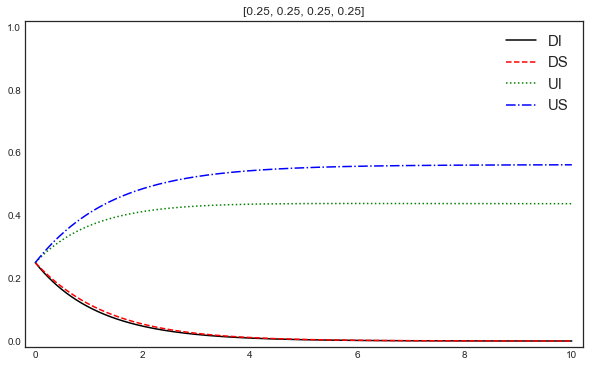

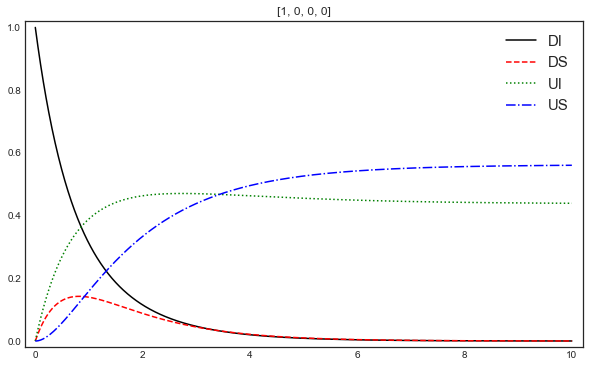

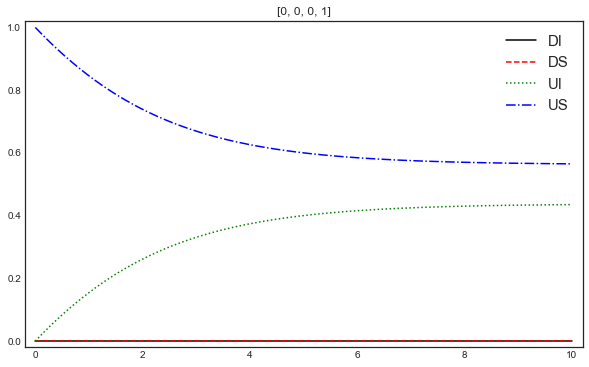

In [5]:
for μ0 in [μ0_1, μ0_2, μ0_3]:
    μ_flow_list, a_flow_list = solve_fixpoint(μ0, param_q, param_f)
    μ_flow_list[-1].plot(**param_plot)
    plt.title(μ0.values.tolist())
    plt.legend(fontsize=15)

# Fig 7.2

The reason $a(T,x) =0$ 0 at the right end is because $g(X_T) \equiv 0$ and action doesn't matter.

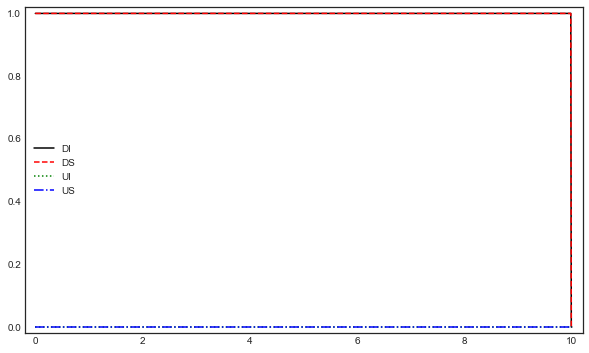

In [6]:
a_flow_list[-1].plot(**param_plot);

# Fig 7.3

In [7]:
μ_flow_list, a_flow_list = solve_fixpoint(μ0_1, param_q2, param_f2, iterations=5)

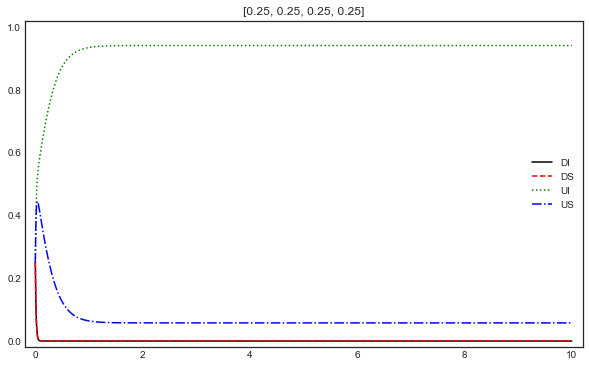

In [8]:
μ_flow_list[0].plot(**param_plot)
plt.title(μ0_1.values.tolist());

## it doesn't iterate

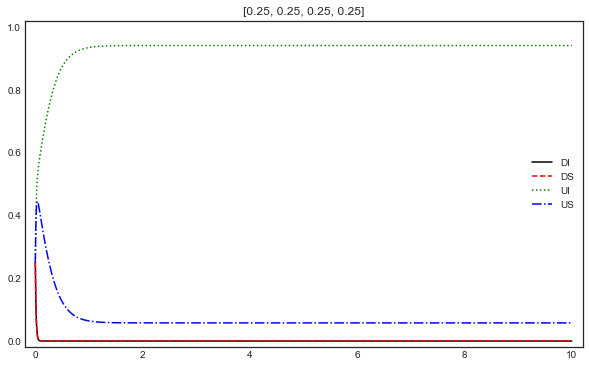

In [9]:
μ_flow_list[-1].plot(**param_plot)
plt.title(μ0_1.values.tolist());

# RL

In [10]:
T = 10
n = 100
dt = T/n
tline = np.linspace(0, T, n+1)

f = get_f(**param_f)
X_mat = np.diag([1]* 4)
E = ['DI', 'DS', 'UI', 'US']
A = [0,1]
ω_q = 0.6
ω_μ = 0.9
ε = 0.9

# ----------- Initialization -----------
q_table = pd.DataFrame(0, index=['DI', 'DS', 'UI', 'US'], columns=A)
μ_flow = pd.DataFrame(1/4, index=tline, columns=['DI', 'DS', 'UI', 'US'])

# make ρ table
ρ_x_df = pd.DataFrame(0, index=tline, columns=[])
ρ_a_df = pd.DataFrame(0, index=tline, columns=[])
p_x_a_df = pd.DataFrame(1, index=E, columns=A)

In [23]:
for k in trange(100,  desc='episode  '):
    q_table_new = copy.deepcopy(q_table)
    μ_flow_new = copy.deepcopy(μ_flow) 
    
    # ρ table for determining learning rate
    ρ_x_df[k] =  pd.Series(0, index=tline)
    ρ_a_df[k] =  pd.Series(0, index=tline)

    # t iteration
    for t in tqdm(range(len(tline)-1), position=0, leave=False, desc='episode {}'.format(k)):
        # ----------- Sample X_t from μ_t -----------
        x_t = np.random.choice(range(4), p=μ_flow.iloc[0])          # should we use t=0 or t=T as in the paper?

        # ----------- update μ_t -----------
        ρ_μ = 1/(1+(k+1))**ω_μ                                      # μ learning rate
        μ_t = μ_flow.iloc[t] + ρ_μ*(X_mat[x_t] - μ_flow.iloc[t])
        μ_flow_new.iloc[t] = μ_t
    



        # ----------- choose action a_t         -----------
        q_min_list = np.min(q_table_new.T.values, axis=0)
        a_min_list = np.argmin(q_table_new.T.values, axis=0)

        # choose action
        if np.random.uniform() <= ε:
            a_t = a_min_list[x_t]
        else:
            a_t = np.random.choice(A)
            
        # determin learning rate
        ρ_x_df.iloc[t, k] = x_t
        ρ_a_df.iloc[t, k] = a_t
        p_x_a_df.iloc[x_t, a_t] += 1                                # add count 
        ρ_q_count = p_x_a_df.iloc[x_t, a_t]                         # q learning rate
        ρ_q = 1/(1 + ρ_q_count)**ω_q

        
        # ----------- observe new state and cost -----------
        P = expm(get_qmat(μ_t, a_t, **param_q) * dt)
        x_t1 = np.random.choice(range(4), p=P[x_t, :])
        
        # ----------- update q table -----------
        q_table_new.iloc[x_t, a_t] = (q_table_new.iloc[x_t, a_t] + 
                                      ρ_q * (f[x_t1]*dt + q_table_new.iloc[x_t1, a_min_list[x_t1]] - q_table_new.iloc[x_t, a_t]))

    μ_flow = μ_flow_new
    μ_flow.iloc[0] = 1/4                                           # should we use fix μ_0????
    q_table = q_table_new

episode  :  37%|███▋      | 3722/10000 [22:23<37:45,  2.77it/s]  


KeyboardInterrupt: 

In [22]:
μ_flow

,DI,DS,UI,US
0.0,0.250000,0.250000,0.250000,0.250000
0.1,0.241030,0.309052,0.259052,0.190866
0.2,0.265624,0.299644,0.252072,0.182660
0.3,0.214493,0.268081,0.267376,0.250050
0.4,0.225156,0.262068,0.245554,0.267221
...,...,...,...,...
9.6,0.261185,0.233775,0.331852,0.173188
9.7,0.194471,0.260488,0.233922,0.311119
9.8,0.253383,0.236550,0.231724,0.278343
9.9,0.345175,0.122769,0.262264,0.269792


<AxesSubplot:>

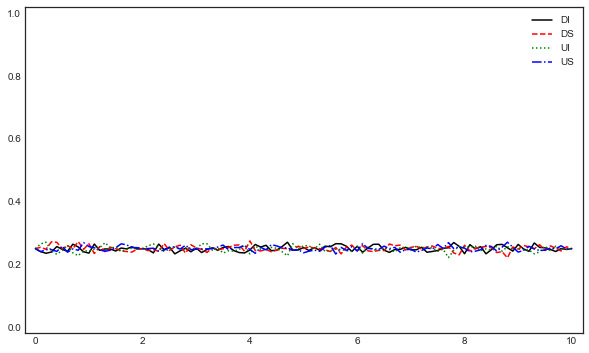

In [24]:
μ_flow.plot(**param_plot)

# RL Version 2

In [56]:
T = 10
n = 100
dt = T/n
tline = np.linspace(0, T, n+1)

f = get_f(**param_f)
X_mat = np.diag([1]* 4)
E = ['DI', 'DS', 'UI', 'US']
A = [0,1]
ω_q = 0.6
ω_μ = 0.9
ε = 0.9

# ----------- Initialization -----------
q_table = pd.DataFrame(0, index=['DI', 'DS', 'UI', 'US'], columns=A)
q_record = []
# μ_flow = pd.DataFrame(1/4, index=tline, columns=['DI', 'DS', 'UI', 'US'])
ν_flow = np.zeros(shape=(len(tline),4,2))
ν_flow[:, 0, :] = 1/2
μ_flow = pd.DataFrame(ν_flow.sum(axis=2), index=tline,columns=E)

# make ρ table
ρ_x_df = pd.DataFrame(0, index=tline, columns=[])
ρ_a_df = pd.DataFrame(0, index=tline, columns=[])
p_x_a_df = pd.DataFrame(1, index=E, columns=A)

In [55]:
ν_flow.sum(axis=2)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [57]:
for k in trange(50,  desc='episode  '):
    q_table_new = copy.deepcopy(q_table)
    μ_flow_new = copy.deepcopy(μ_flow) 
    ν_flow_new = copy.deepcopy(ν_flow) 

    # ρ table for determining learning rate
    ρ_x_df[k] =  pd.Series(0, index=tline)
    ρ_a_df[k] =  pd.Series(0, index=tline)

    # t iteration
    for t in tqdm(range(len(tline)-1), position=0, leave=False, desc='episode {}'.format(k)):
        # ----------- Sample X_t from μ_t -----------
        x_t = np.random.choice(range(4), p=μ_flow.iloc[0])          # should we use t=0 or t=T as in the paper?
        ν_t = ν_flow[t]
        # ----------- update μ_t -----------
        ρ_μ = 1/(1+(k+1))**ω_μ                                      # μ learning rate
#         μ_t = μ_flow.iloc[t] + ρ_μ*(X_mat[x_t] - μ_flow.iloc[t])
#         μ_flow_new.iloc[t] = μ_t
    



        # ----------- choose action a_t         -----------
        q_min_list = np.min(q_table_new.T.values, axis=0)
        a_min_list = np.argmin(q_table_new.T.values, axis=0)

        # choose action
        if np.random.uniform() <= ε:
            a_t = a_min_list[x_t]
        else:
            a_t = np.random.choice(A)
            
        # determin learning rate
        ρ_x_df.iloc[t, k] = x_t
        ρ_a_df.iloc[t, k] = a_t
        p_x_a_df.iloc[x_t, a_t] += 1                                # add count 
        ρ_q_count = p_x_a_df.iloc[x_t, a_t]                         # q learning rate
        ρ_q = 1/(1 + ρ_q_count)**ω_q
        
        # update ν (μ is marginal of ν)
        choice = np.zeros((4,2))
        choice[x_t,a_t]=1
        ν_t = ν_t+ρ_μ*(choice-ν_t)     #need to consider different learning rate
        ν_flow_new[t] = ν_t
        μ_t = pd.Series(ν_t.sum(axis=1), index=E)
        μ_flow_new.iloc[t] = μ_t
        
        # ----------- observe new state and cost -----------
        P = expm(get_qmat(μ_t, a_t, **param_q) * dt)
        x_t1 = np.random.choice(range(4), p=P[x_t, :])
        
        # ----------- update q table -----------
        q_table_new.iloc[x_t, a_t] = (q_table_new.iloc[x_t, a_t] + 
                                      ρ_q * (f[x_t1]*dt + q_table_new.iloc[x_t1, a_min_list[x_t1]] - q_table_new.iloc[x_t, a_t]))

    μ_flow = μ_flow_new
#     μ_flow.iloc[0] = 1/4                                           # should we use fix μ_0????
    ν_flow = ν_flow_new
    q_record.append(q_table)
    q_table = q_table_new

episode  : 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]    


<AxesSubplot:>

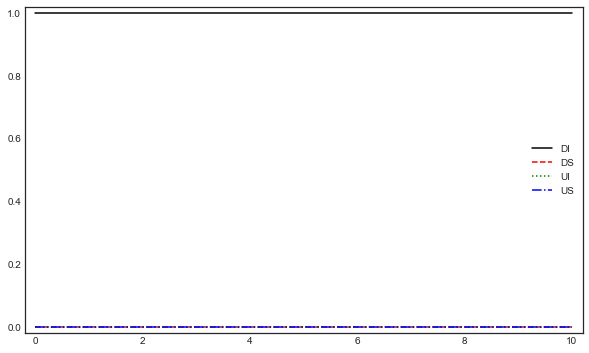

In [58]:
μ_flow.plot(**param_plot)

In [59]:
q_record

[    0  1
 DI  0  0
 DS  0  0
 UI  0  0
 US  0  0,
           0         1
 DI  0.42466  0.427229
 DS  0.00000  0.000000
 UI  0.00000  0.000000
 US  0.00000  0.000000,
            0         1
 DI  0.619553  0.616528
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.628187  0.439893
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.607323  0.602337
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.677525  0.644058
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.715594  0.681829
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.723048  0.719387
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.000000  0.000000,
            0         1
 DI  0.744091  0.661658
 DS  0.000000  0.000000
 UI  0.000000  0.000000
 US  0.0000

In [60]:
q_table


,0,1
DI,0.743553,0.719185
DS,0.000000,0.000000
UI,0.000000,0.000000
US,0.000000,0.000000
